In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')


In [2]:
from sys import path
path.append('..')
from convexcontrol.main import Controller
from convexcontrol.resources import PVSys, Battery, TCL

In [3]:
res_load_df = pd.read_csv("../../simulation_data/res_avg_load_data_5min_2days.csv")

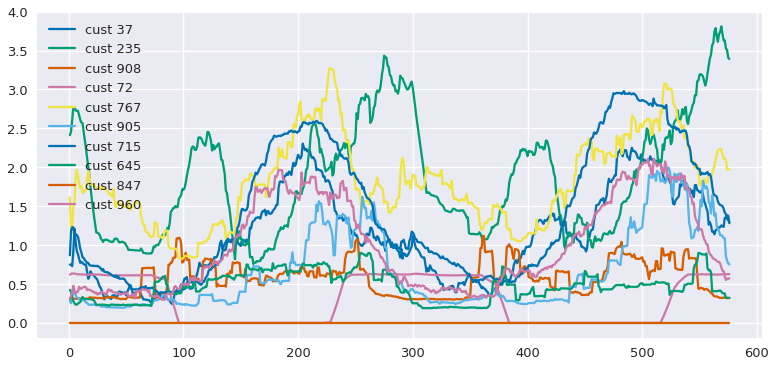

In [4]:
# check the real residential load 
H = 2*12*24+1; 

np.random.seed(1)
plt.figure(figsize=(13,6))
for j in np.random.randint(0, 1000, 10):
    plt.plot(range(1, H), res_load_df.iloc[j,1:].values, label="cust %d"%j)
    
plt.legend()    

In [5]:
solar_df = pd.read_pickle("../../simulation_data/solar_data.pkl")
solar_cap = pd.read_csv("../../simulation_data/solar_capacities.csv", header=None)

## Test on R1 case 

In [6]:
# pick solor site S16 
solar_data_1 = np.round(solar_df["S16"].values, 4)
solar_data_1_cap = solar_cap.iloc[16, 1]

In [7]:
# pick idx=960 customer 
res_load_1 = res_load_df.iloc[43, 1:]

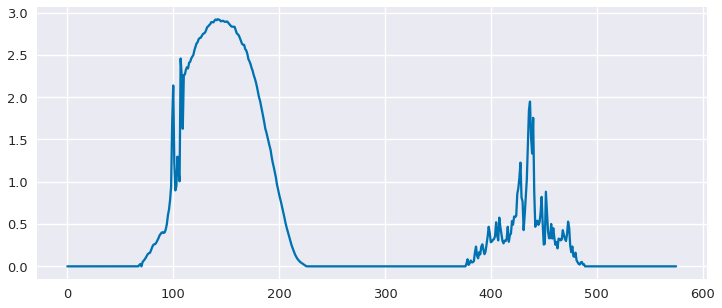

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(solar_data_1)

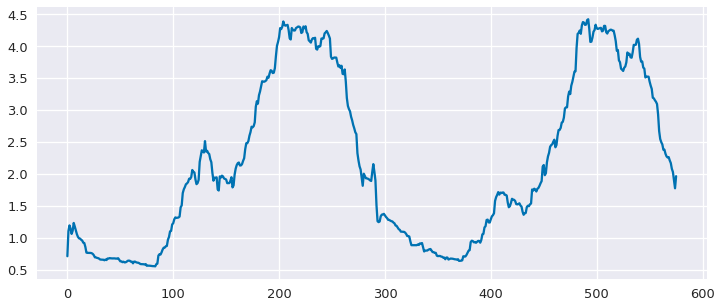

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(res_load_1.values)

In [10]:
def roundDigits(x, decimal_n=3):
    return np.round(x.values.tolist(), decimal_n)

def vis_results(agg_points, H, output2):
    fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(14, 10))
    ax[0].plot(range(1, H), agg_points)
    ax[0].plot(range(1, H), output2['PCC imp'])
    ax[1].plot(range(1, H), output2['pv2 req'])
    ax[1].plot(range(1, H), output2['pv2 imp'])
    ax[2].plot(range(1, H), roundDigits(output2['batt2 req']))
    ax[2].plot(range(1, H), roundDigits(output2['batt2 imp']))
    ax[3].plot(range(1, H), roundDigits(output2['batt2 SoC']))
    ax[4].plot(range(1, H), roundDigits(output2['hvac2 req'], decimal_n=2))
    ax[4].plot(range(1, H), roundDigits(output2['hvac2 imp'], decimal_n=2))
    ax[-1].set_xlabel('time step')
    ax[0].set_ylabel('kW')
    ax[1].set_ylabel('kW')
    ax[2].set_ylabel('kW')
    ax[3].set_ylabel('SoC')
    ax[4].set_ylabel('kW')
    ax[0].set_title('Aggregate Set Point Signal')
    ax[1].set_title('PV Power Signal')
    ax[2].set_title('Battery Power Signal')
    ax[3].set_title('Battery SoC')
    ax[4].set_title('TCL Power Signal')
    ax[4].legend(['requested', 'implemented'], loc=(1.01, .1))
    plt.show()

In [11]:
def vis_results_cum(agg_points, H, output2):
    fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(14, 8))
    ax[0].plot(range(1, H), np.cumsum(agg_points))
    ax[0].plot(range(1, H), roundDigits(np.cumsum(output2['PCC imp'])))
    ax[1].plot(range(1, H), np.cumsum(output2['pv2 req']))
    ax[1].plot(range(1, H), np.cumsum(output2['pv2 imp']))
    ax[2].plot(range(1, H), np.cumsum(output2['batt2 req']))
    ax[2].plot(range(1, H), np.cumsum(output2['batt2 imp']))
    ax[3].plot(range(1, H), roundDigits(np.cumsum(output2['hvac2 req']), decimal_n=2))
    ax[3].plot(range(1, H), roundDigits(np.cumsum(output2['hvac2 imp']), decimal_n=2))
    ax[-1].set_xlabel('time step')
    ax[0].set_ylabel('kWh')
    ax[1].set_ylabel('kWh')
    ax[2].set_ylabel('kWh')
    ax[3].set_ylabel('kWh')
    ax[0].set_title('Total Aggregate Energy')
    ax[1].set_title('Total PV Energy')
    ax[2].set_title('Total Battery Energy')
    ax[3].set_title('Total TCL Energy')
    ax[3].legend(['requested', 'implemented'], loc=(1.01, .1))
    plt.show()

In [12]:
agg_point = np.round(res_load_1.values.tolist(), decimals=3)

### without error diffusion 

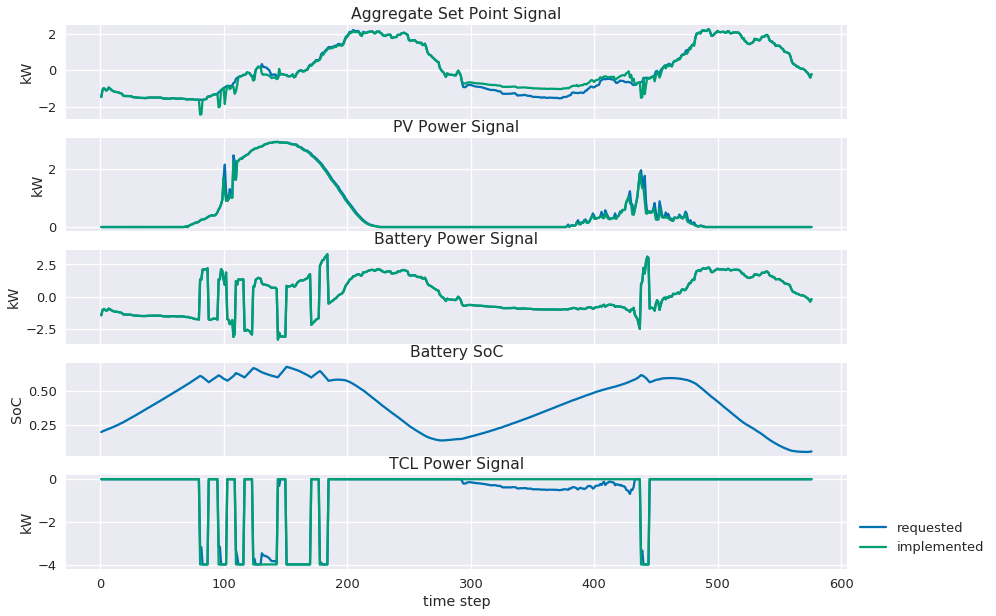

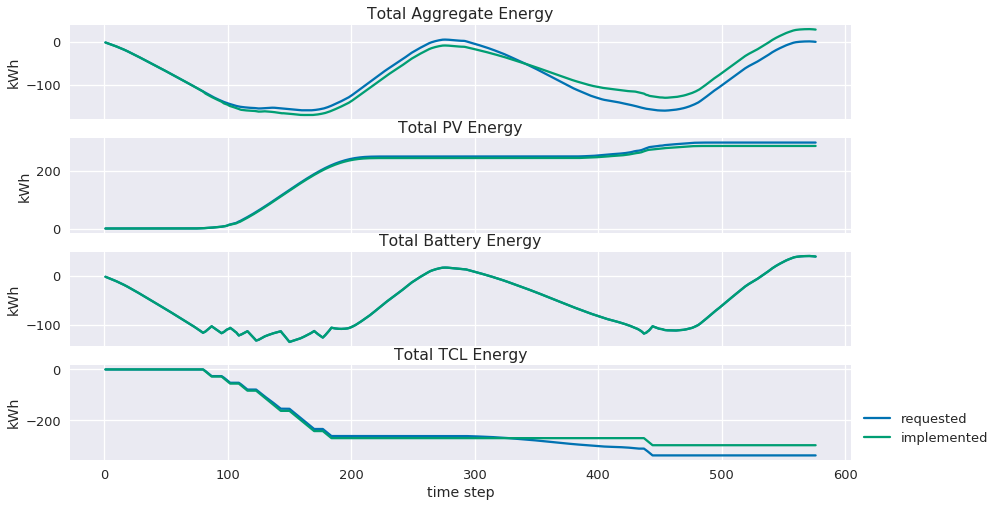

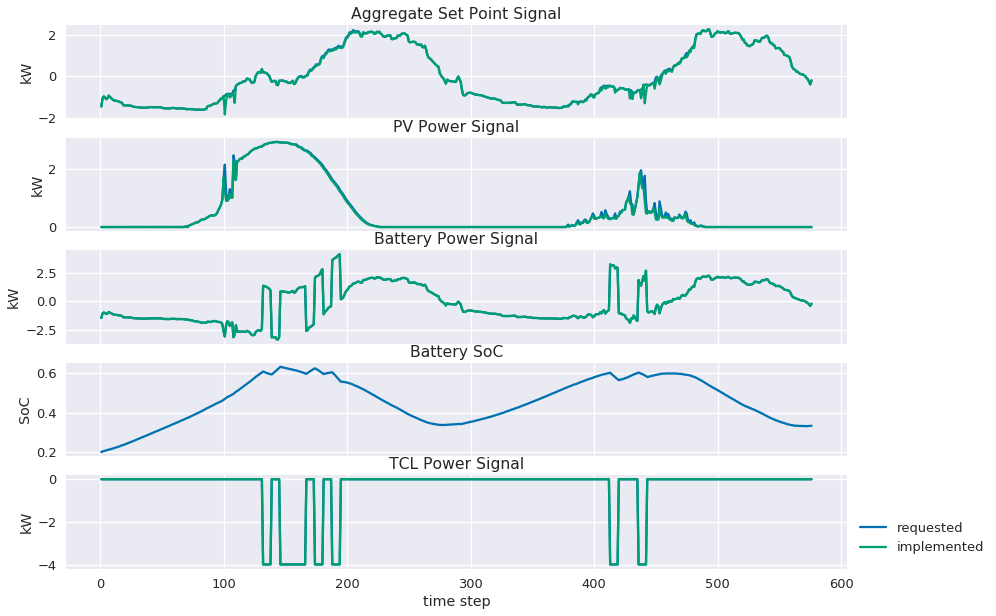

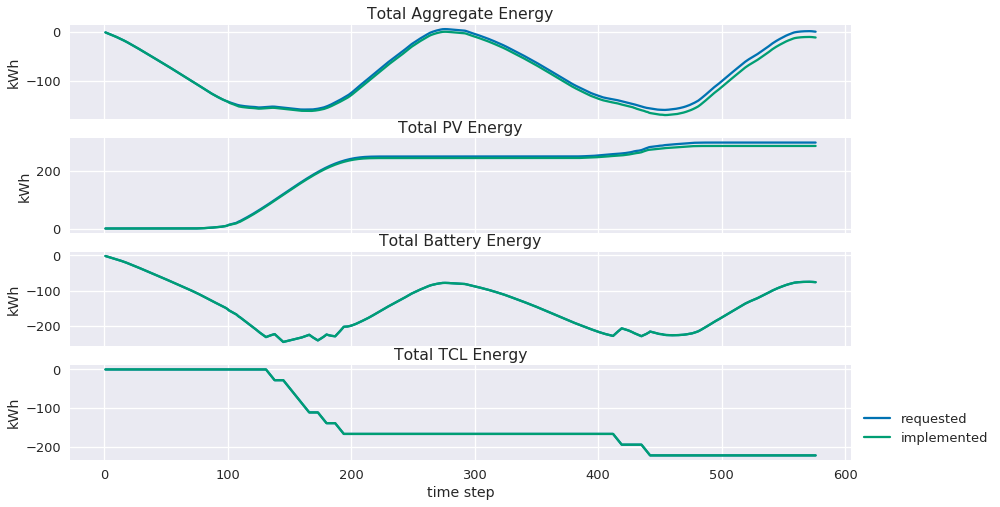

In [13]:
for cap in [5, 10]: # different battery size 
    controll_nondiffuse = Controller(mu=1e3)
    controll_nondiffuse.addResource(PVSys('pv2', data=solar_data_1, pmax=solar_data_1_cap, T=576))
    controll_nondiffuse.addResource(Battery('batt2', target_SoC=0.6, initial_SoC=0.2, Cb=1e-1, capacity=cap, pmin=-0.9*cap, pmax=0.9*cap))
    controll_nondiffuse.addResource(TCL('hvac2', Chvac=1e-1, pmax= -0.9*max(agg_point), T=576))
    output = controll_nondiffuse.runSimulation(agg_point-np.mean(agg_point), error_diffusion=False, solver='MOSEK')
    vis_results(agg_point-np.mean(agg_point), H, output)   
    vis_results_cum(agg_point-np.mean(agg_point), H, output)

### with error diffusion

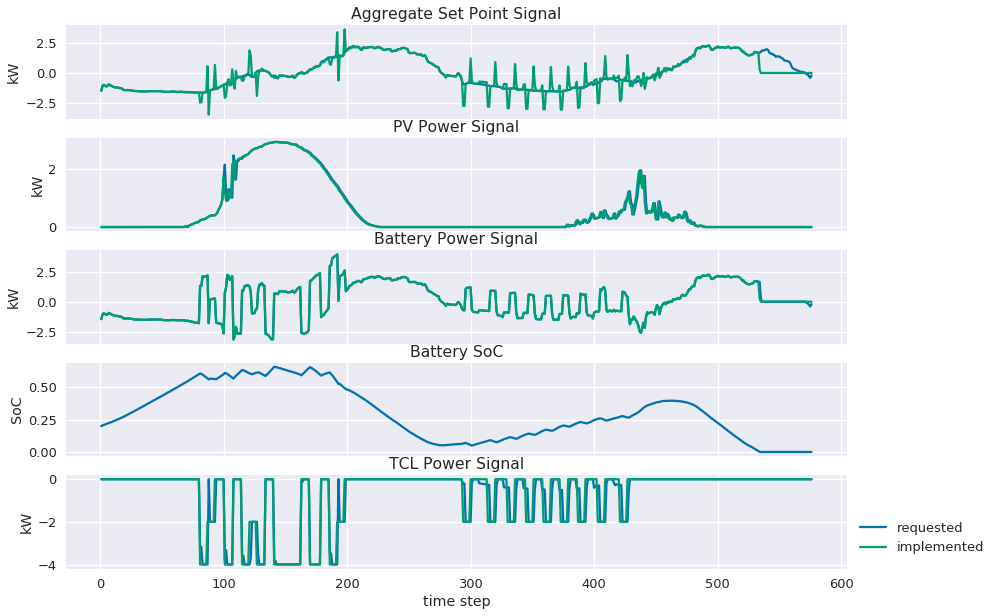

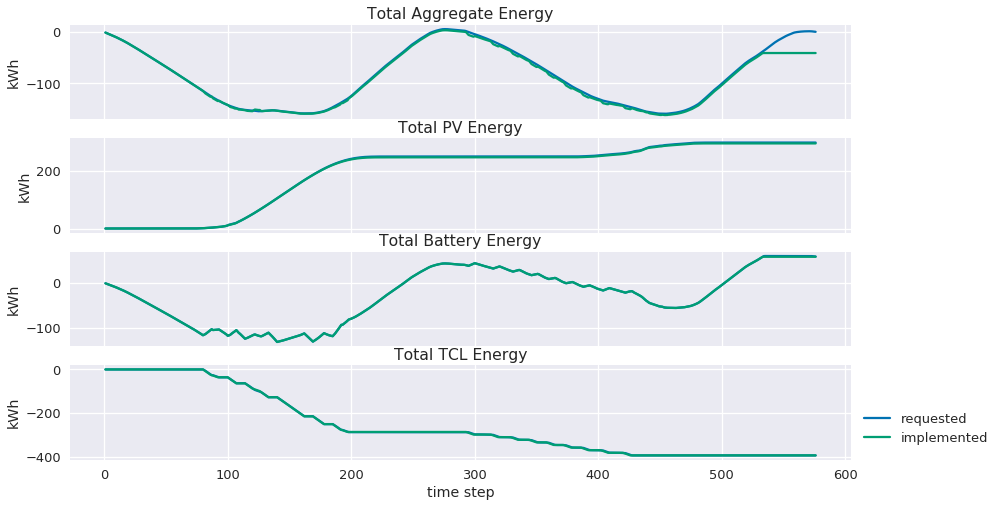

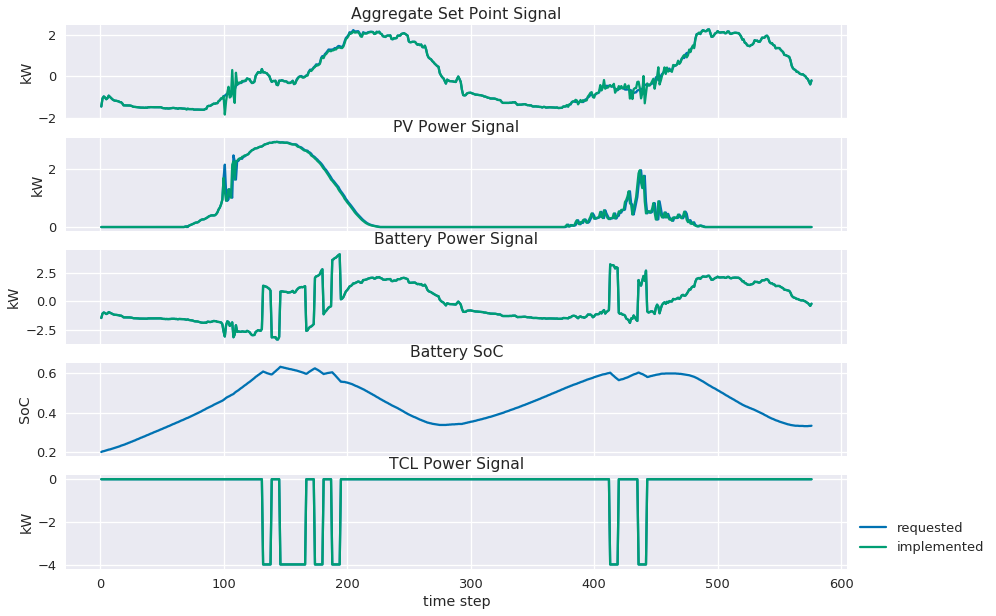

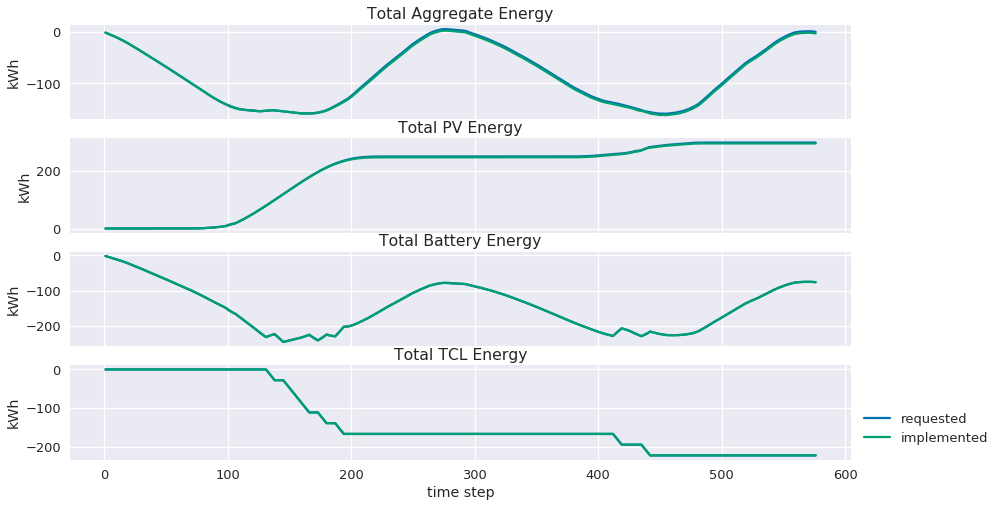

In [14]:
for cap in [5, 10]:
    controll_diffuse = Controller(mu=1e3)
    controll_diffuse.addResource(PVSys('pv2', data=solar_data_1, pmax=solar_data_1_cap, T=576))
    controll_diffuse.addResource(Battery('batt2', target_SoC=0.6, initial_SoC=0.2, Cb=1e-1, capacity=cap, pmin=-0.9*cap, pmax=0.9*cap))
    controll_diffuse.addResource(TCL('hvac2', Chvac=1e-1, pmax= -0.9*max(agg_point), T=576))
    output2 = controll_diffuse.runSimulation(agg_point-np.mean(agg_point), error_diffusion=True, solver='MOSEK')
    vis_results(agg_point-np.mean(agg_point), H, output2)
    vis_results_cum(agg_point-np.mean(agg_point), H, output2)